# Dynamic Programming

## Explore FrozenLakeEnv

Use the code cell below to create an instance of the [FrozenLake](https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py) environment.

In [3]:
from frozenlake import FrozenLakeEnv
env = FrozenLakeEnv()

The agent moves through a $4 \times 4$ gridworld, with states numbered as follows:
```
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
```
and the agent has 4 potential actions:
```
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
```

Thus, $\mathcal{S}^+ = \{0, 1, \ldots, 15\}$, and $\mathcal{A} = \{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [4]:
# print the state space and action space
print(env.observation_space)
print(env.action_space)

# print the total number of states and actions
print('Number of States: ' + str(env.nS))
print('Number of Actions: ' + str(env.nA))

Discrete(16)
Discrete(4)
Number of States: 16
Number of Actions: 4


Dynamic programming assumes that the **agent has full knowledge of the MDP**.  The environment has been loaded with `frozenlake.py` file to make the one-step dynamics accessible to the agent.  

Each State `env.P[1][0]` :  **Returns the the probability of each possible REWARD and next STATE, if the agent is in state 1 of the gridworld and decides to go left.** This also known as __transition probability__. If there there is a uncertainty in environment this will have individual probability for each action to state.

Each **State-Action pair** will have list of tuples, That represents ```(prob, next_state, reward, done)```. And here we have 2 cases to be discussed.
1. **Slippery:** This assume that the agent can slip from it's actual **next state** by it's action.<br> 
   > Ex: When we create a FrozenLake environment, it takes as an (optional) argument `is_slippery`, which defaults   to `True`. In this case, the **single action** from a state leads to **next 3 possible states**. Because the _environment is uncertain_. The result will be like below for `env = FrozenLakeEnv(is_slippery=True)`.
   ```
   {0: [(0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 4, 0.0, False)]
   ```
2. **Non-slippery:** If it's not non slippery. Then each state-action leads to a single possilbe state as next state. 
> The result will be like below for `env = FrozenLakeEnv(is_slippery=False)`. This can result in the agent moving in a direction that it did not intend (where the idea is that the ground is slippery, and so the agent can slide to a location other than the one it wanted)
```
env.P[1][0] = [(1.0, 0, 0.0, False)]
```

In [5]:
for actions in env.P[0]:
    print('Action {} with State'.format(actions, 0))
    for states in env.P[0][actions]:
        print('\t State {} with {} probability'.format(states[1], states[0]))
        

Action 0 with State
	 State 0 with 0.3333333333333333 probability
	 State 0 with 0.3333333333333333 probability
	 State 4 with 0.3333333333333333 probability
Action 1 with State
	 State 0 with 0.3333333333333333 probability
	 State 4 with 0.3333333333333333 probability
	 State 1 with 0.3333333333333333 probability
Action 2 with State
	 State 4 with 0.3333333333333333 probability
	 State 1 with 0.3333333333333333 probability
	 State 0 with 0.3333333333333333 probability
Action 3 with State
	 State 1 with 0.3333333333333333 probability
	 State 0 with 0.3333333333333333 probability
	 State 0 with 0.3333333333333333 probability


Each entry takes the form 
```
prob, next_state, reward, done
```
where: 
- `prob` details the conditional probability or transition probability of the corresponding (`next_state`, `reward`) pair, and
- `done` is `True` if the `next_state` is a terminal state, and otherwise `False`.

Thus, we can interpret `env.P[1][0]` as follows:
$$
\mathbb{P}(S_{t+1}=s',R_{t+1}=r|S_t=1,A_t=0) = \begin{cases}
               \frac{1}{3} \text{ if } s'=1, r=0\\
               \frac{1}{3} \text{ if } s'=0, r=0\\
               \frac{1}{3} \text{ if } s'=5, r=0\\
               0 \text{ else}
            \end{cases}
$$

## Iterative Policy Evaluation (State value calculation)
<img src="images/policy-eval.png" width="600">
Your algorithm should accept four arguments as **input**:
- `env`: This is an instance of an OpenAI Gym environment, where `env.P` returns the one-step dynamics.
- `policy`: This is a 2D numpy array with `policy.shape[0]` equal to the number of states (`env.nS`), and `policy.shape[1]` equal to the number of actions (`env.nA`).  `policy[s][a]` returns the probability that the agent takes action `a` while in state `s` under the policy.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).
- `theta`: This is a very small positive number that is used to decide if the estimate has sufficiently converged to the true value function (default value: `1e-8`).

The algorithm returns as **output**:
- `V`: This is a 1D numpy array with `V.shape[0]` equal to the number of states (`env.nS`).  `V[s]` contains the estimated value of state `s` under the input policy.

`action_prob` is `policy[s][a]` that returns the **probability that the agent takes action “a” while in state “s” under the policy**.

`prob` is the transition probability for the stochastic policy which we discussed earlier for the frozen-lake environment. Transition probability is when despite the intended action to be performed by the agent, there is a probability that the agent might still end up in some other state.

In [6]:
import numpy as np

def policy_evaluation(env, policy, gamma=1, theta=1e-8):
    # Set all states to 0.
    V = np.zeros(env.nS)
    count = 0
    while True:
        print('\nIteration: ' + str(count))

        delta = 0
        for s in range(env.nS):
            Vs = 0

            # Each State with 4 possible actions.
            # action_prob : Stochastic probability (π(a|s))
            for a, action_prob in enumerate(policy[s]):

                # Each Action will have 3 possible next states, Because according to Froze Env, When the state is
                # Slippery then the next state is uncertain.
                for prob, next_state, reward, done in env.P[s][a]:

                    # Initially the V[next_state] value will be 0, Through the itrations this will be improved.
                    Vs += action_prob * prob * (reward + gamma * V[next_state])
            
            print('Initial State: ' + str(s) + ', State value improved by :' + str(Vs))
            delta = max(delta, np.abs(V[s]-Vs))
            V[s] = Vs
        if delta < theta:
            break
        count = count + 1
    return V

In [7]:
V = np.zeros(env.nS)

We will evaluate the equiprobable random policy $\pi$, where $\pi(a|s) = \frac{1}{|\mathcal{A}(s)|}$ for all $s\in\mathcal{S}$ and $a\in\mathcal{A}(s)$.  

Use the code cell below to specify this policy in the variable `random_policy`.

In [8]:
random_policy = np.ones([env.nS, env.nA]) / env.nA
random_policy

array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25]])

Run the next code cell to evaluate the equiprobable random policy and visualize the output.  The state-value function has been reshaped to match the shape of the gridworld.

In [9]:
from plot_utils import plot_values

# evaluate the policy 
V = policy_evaluation(env, random_policy, gamma=1)


Iteration: 0
Initial State: 0, State value improved by :0.0
Initial State: 1, State value improved by :0.0
Initial State: 2, State value improved by :0.0
Initial State: 3, State value improved by :0.0
Initial State: 4, State value improved by :0.0
Initial State: 5, State value improved by :0.0
Initial State: 6, State value improved by :0.0
Initial State: 7, State value improved by :0.0
Initial State: 8, State value improved by :0.0
Initial State: 9, State value improved by :0.0
Initial State: 10, State value improved by :0.0
Initial State: 11, State value improved by :0.0
Initial State: 12, State value improved by :0.0
Initial State: 13, State value improved by :0.0
Initial State: 14, State value improved by :0.25
Initial State: 15, State value improved by :0.0

Iteration: 1
Initial State: 0, State value improved by :0.0
Initial State: 1, State value improved by :0.0
Initial State: 2, State value improved by :0.0
Initial State: 3, State value improved by :0.0
Initial State: 4, State v

/Users/dhanushanthp/anaconda3/envs/quadcop/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


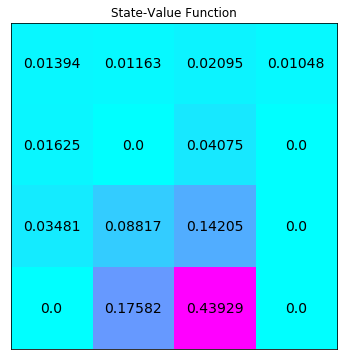

In [10]:
plot_values(V)

Run the code cell below to test your function.  If the code cell returns **PASSED**, then you have implemented the function correctly!  

**Note:** In order to ensure accurate results, make sure that your `policy_evaluation` function satisfies the requirements outlined above (with four inputs, a single output, and with the default values of the input arguments unchanged).

In [11]:
import check_test

check_test.run_check('policy_evaluation_check', policy_evaluation)


Iteration: 0
Initial State: 0, State value improved by :0.0
Initial State: 1, State value improved by :0.0
Initial State: 2, State value improved by :0.0
Initial State: 3, State value improved by :0.0
Initial State: 4, State value improved by :0.0
Initial State: 5, State value improved by :0.0
Initial State: 6, State value improved by :0.0
Initial State: 7, State value improved by :0.0
Initial State: 8, State value improved by :0.0
Initial State: 9, State value improved by :0.0
Initial State: 10, State value improved by :0.0
Initial State: 11, State value improved by :0.0
Initial State: 12, State value improved by :0.0
Initial State: 13, State value improved by :0.0
Initial State: 14, State value improved by :0.25
Initial State: 15, State value improved by :0.0

Iteration: 1
Initial State: 0, State value improved by :0.0
Initial State: 1, State value improved by :0.0
Initial State: 2, State value improved by :0.0
Initial State: 3, State value improved by :0.0
Initial State: 4, State v

**<span style="color: green;">PASSED</span>**

## Part 2: Obtain Action value from State value
### Calculate the action-value from state-value function
<img src="images/est-action.png" width="600">
In this section, you will write a function that takes the state-value function estimate as input, along with some state $s\in\mathcal{S}$.  It returns the **row in the action-value function** corresponding to the input state $s\in\mathcal{S}$.  That is, your function should accept as input both $v_\pi$ and $s$, and return $q_\pi(s,a)$ for all $a\in\mathcal{A}(s)$.

Your algorithm should accept four arguments as **input**:
- `env`: This is an instance of an OpenAI Gym environment, where `env.P` returns the one-step dynamics.
- `V`: This is a 1D numpy array with `V.shape[0]` equal to the number of states (`env.nS`).  `V[s]` contains the estimated value of state `s`.
- `s`: This is an integer corresponding to a state in the environment.  It should be a value between `0` and `(env.nS)-1`, inclusive.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as **output**:
- `q`: This is a 1D numpy array with `q.shape[0]` equal to the number of actions (`env.nA`).  `q[a]` contains the (estimated) value of state `s` and action `a`.

Please complete the function in the code cell below.

In [12]:
def q_from_v(env, V, s, gamma=1):
    # Each state will have nA number of possible actions.
    q = np.zeros(env.nA)
    for a in range(env.nA):
        for prob, next_state, reward, done in env.P[s][a]:
            # Calculate each action value from pre-trained state values.
            q[a] += prob * (reward + gamma * V[next_state])
    return q

Run the code cell below to print the action-value function corresponding to the above state-value function.

In [13]:
Q = np.zeros([env.nS, env.nA])
count = 0
for s in range(env.nS):
    Q[s] = q_from_v(env, V, s)
    print('State : %s' % count)
    count = count + 1
print("Action-Value Function:")
print(Q)

State : 0
State : 1
State : 2
State : 3
State : 4
State : 5
State : 6
State : 7
State : 8
State : 9
State : 10
State : 11
State : 12
State : 13
State : 14
State : 15
Action-Value Function:
[[0.0147094  0.01393978 0.01393978 0.01317015]
 [0.00852356 0.01163091 0.0108613  0.01550788]
 [0.02444514 0.02095298 0.02406033 0.01435346]
 [0.01047649 0.01047649 0.00698432 0.01396865]
 [0.02166487 0.01701828 0.01624865 0.01006281]
 [0.         0.         0.         0.        ]
 [0.05433538 0.04735105 0.05433538 0.00698432]
 [0.         0.         0.         0.        ]
 [0.01701828 0.04099204 0.03480619 0.04640826]
 [0.07020885 0.11755991 0.10595784 0.05895312]
 [0.18940421 0.17582037 0.16001424 0.04297382]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.08799677 0.20503718 0.23442716 0.17582037]
 [0.25238823 0.53837051 0.52711478 0.43929118]
 [0.         0.         0.         0.        ]]


Run the code cell below to test your function.  If the code cell returns **PASSED**, then you have implemented the function correctly!  

**Note:** In order to ensure accurate results, make sure that the `q_from_v` function satisfies the requirements outlined above (with four inputs, a single output, and with the default values of the input arguments unchanged).

In [14]:
check_test.run_check('q_from_v_check', q_from_v)

**<span style="color: green;">PASSED</span>**

## Policy Improvement
WE will be improving the **POLICY** by **picking the highest value of actions in each State**.
<img src="images/improve.png" width="600">
So based on the action value the policy changes. And when the policy change then the action for a state will be changed automatically.

The algorithm should accept three arguments as **input**:
- `env`: This is an instance of an OpenAI Gym environment, where `env.P` returns the one-step dynamics.
- `V`: This is a 1D numpy array with `V.shape[0]` equal to the number of states (`env.nS`).  `V[s]` contains the estimated value of state `s`.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as **output**:
- `policy`: This is a 2D numpy array with `policy.shape[0]` equal to the number of states (`env.nS`), and `policy.shape[1]` equal to the number of actions (`env.nA`).  `policy[s][a]` returns the probability that the agent takes action `a` while in state `s` under the policy.

Please complete the function in the code cell below.  You are encouraged to use the `q_from_v` function you implemented above.

In [31]:
def policy_improvement(env, V, gamma=1):
    policy = np.zeros([env.nS, env.nA]) / env.nA
    print("State Values: {}\n".format(V))
    for s in range(env.nS):
        q = q_from_v(env, V, s, gamma)
        print("State: {}, Action value: {}".format(s, q))
        
        # OPTION 1: construct a deterministic policy 
        # policy[s][np.argmax(q)] = 1
        
        # OPTION 2: construct a stochastic policy that puts equal probability on maximizing actions
        best_a = np.argwhere(q==np.max(q)).flatten()
        print("Best Action for next episode: {}\n".format(best_a))
        policy[s] = np.sum([np.eye(env.nA)[i] for i in best_a], axis=0)/len(best_a)
        
    print("Matrix best Action for next episode's each state:\n {}".format(policy))
    return policy

Run the code cell below to test your function.  If the code cell returns **PASSED**, then you have implemented the function correctly!  

**Note:** In order to ensure accurate results, make sure that the `policy_improvement` function satisfies the requirements outlined above (with three inputs, a single output, and with the default values of the input arguments unchanged).

Before moving on to the next part of the notebook, you are strongly encouraged to check out the solution in **Dynamic_Programming_Solution.ipynb**.  There are many correct ways to approach this function!

In [32]:
check_test.run_check('policy_improvement_check', policy_improvement)

State Values: [0.01393977 0.01163091 0.02095297 0.01047648 0.01624865 0.
 0.04075153 0.         0.03480619 0.08816993 0.14205316 0.
 0.         0.17582037 0.43929118 0.        ]

State: 0, Action value: [0.0147094  0.01393978 0.01393978 0.01317015]
Best Action for next episode: [0]

State: 1, Action value: [0.00852356 0.01163091 0.0108613  0.01550788]
Best Action for next episode: [3]

State: 2, Action value: [0.02444514 0.02095298 0.02406033 0.01435346]
Best Action for next episode: [0]

State: 3, Action value: [0.01047649 0.01047649 0.00698432 0.01396865]
Best Action for next episode: [3]

State: 4, Action value: [0.02166487 0.01701828 0.01624865 0.01006281]
Best Action for next episode: [0]

State: 5, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 6, Action value: [0.05433538 0.04735105 0.05433538 0.00698432]
Best Action for next episode: [0 2]

State: 7, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 8, Action value: [0.0170

**<span style="color: green;">PASSED</span>**

## Policy Iteration
<img src="images/iteration.png" width="600">
In this section, you will write your own implementation of policy iteration.  The algorithm returns the optimal policy, along with its corresponding state-value function.

Your algorithm should accept three arguments as **input**:
- `env`: This is an instance of an OpenAI Gym environment, where `env.P` returns the one-step dynamics.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).
- `theta`: This is a very small positive number that is used to decide if the policy evaluation step has sufficiently converged to the true value function (default value: `1e-8`).

The algorithm returns as **output**:
- `policy`: This is a 2D numpy array with `policy.shape[0]` equal to the number of states (`env.nS`), and `policy.shape[1]` equal to the number of actions (`env.nA`).  `policy[s][a]` returns the probability that the agent takes action `a` while in state `s` under the policy.
- `V`: This is a 1D numpy array with `V.shape[0]` equal to the number of states (`env.nS`).  `V[s]` contains the estimated value of state `s`.

Please complete the function in the code cell below.  You are strongly encouraged to use the `policy_evaluation` and `policy_improvement` functions you implemented above.

In [33]:
import copy

def policy_iteration(env, gamma=1, theta=1e-8):
    policy = np.ones([env.nS, env.nA]) / env.nA
    while True:
        V = policy_evaluation(env, policy, gamma, theta)
        new_policy = policy_improvement(env, V)
        
        # OPTION 1: stop if the policy is unchanged after an improvement step
        if (new_policy == policy).all():
            break;
        
        # OPTION 2: stop if the value function estimates for successive policies has converged
        # if np.max(abs(policy_evaluation(env, policy) - policy_evaluation(env, new_policy))) < theta*1e2:
        #    break;
        
        policy = copy.copy(new_policy)
    return policy, V

Run the next code cell to solve the MDP and visualize the output.  The optimal state-value function has been reshaped to match the shape of the gridworld.

**Compare the optimal state-value function to the state-value function from Part 1 of this notebook**.  _Is the optimal state-value function consistently greater than or equal to the state-value function for the equiprobable random policy?_


Iteration: 0
Initial State: 0, State value improved by :0.0
Initial State: 1, State value improved by :0.0
Initial State: 2, State value improved by :0.0
Initial State: 3, State value improved by :0.0
Initial State: 4, State value improved by :0.0
Initial State: 5, State value improved by :0.0
Initial State: 6, State value improved by :0.0
Initial State: 7, State value improved by :0.0
Initial State: 8, State value improved by :0.0
Initial State: 9, State value improved by :0.0
Initial State: 10, State value improved by :0.0
Initial State: 11, State value improved by :0.0
Initial State: 12, State value improved by :0.0
Initial State: 13, State value improved by :0.0
Initial State: 14, State value improved by :0.25
Initial State: 15, State value improved by :0.0

Iteration: 1
Initial State: 0, State value improved by :0.0
Initial State: 1, State value improved by :0.0
Initial State: 2, State value improved by :0.0
Initial State: 3, State value improved by :0.0
Initial State: 4, State v

Initial State: 6, State value improved by :0.30358717682275194
Initial State: 7, State value improved by :0.0
Initial State: 8, State value improved by :0.5253476662712113
Initial State: 9, State value improved by :0.6160149038121059
Initial State: 10, State value improved by :0.5948699258475645
Initial State: 11, State value improved by :0.0
Initial State: 12, State value improved by :0.0
Initial State: 13, State value improved by :0.7379375377132139
Initial State: 14, State value improved by :0.8676484115403498
Initial State: 15, State value improved by :0.0

Iteration: 27
Initial State: 0, State value improved by :0.42197787980076257
Initial State: 1, State value improved by :0.36505164118533634
Initial State: 2, State value improved by :0.3298311052436459
Initial State: 3, State value improved by :0.31032352355591863
Initial State: 4, State value improved by :0.466821460428287
Initial State: 5, State value improved by :0.0
Initial State: 6, State value improved by :0.30823367703040

Initial State: 11, State value improved by :0.0
Initial State: 12, State value improved by :0.0
Initial State: 13, State value improved by :0.8491818639302758
Initial State: 14, State value improved by :0.9245409496121559
Initial State: 15, State value improved by :0.0

Iteration: 103
Initial State: 0, State value improved by :0.7665701923810885
Initial State: 1, State value improved by :0.6471395499119781
Initial State: 2, State value improved by :0.5285574808844248
Initial State: 3, State value improved by :0.52778894106065
Initial State: 4, State value improved by :0.7683178116736324
Initial State: 5, State value improved by :0.0
Initial State: 6, State value improved by :0.41050642680691796
Initial State: 7, State value improved by :0.0
Initial State: 8, State value improved by :0.7710110638622973
Initial State: 9, State value improved by :0.774384909109634
Initial State: 10, State value improved by :0.703144095176236
Initial State: 11, State value improved by :0.0
Initial State: 1

Initial State: 6, State value improved by :0.4144272010422821
Initial State: 7, State value improved by :0.0
Initial State: 8, State value improved by :0.7800126836910721
Initial State: 9, State value improved by :0.780181833122922
Initial State: 10, State value improved by :0.7071078588158528
Initial State: 11, State value improved by :0.0
Initial State: 12, State value improved by :0.0
Initial State: 13, State value improved by :0.8534434905836328
Initial State: 14, State value improved by :0.9267193442886623
Initial State: 15, State value improved by :0.0

Iteration: 174
Initial State: 0, State value improved by :0.7798192442858863
Initial State: 1, State value improved by :0.6579891057766911
Initial State: 2, State value improved by :0.5361997302045824
Initial State: 3, State value improved by :0.536162811843774
Initial State: 4, State value improved by :0.7799031947040619
Initial State: 5, State value improved by :0.0
Initial State: 6, State value improved by :0.4144358630068117
I

Initial State: 14, State value improved by :0.9268262395177556
Initial State: 15, State value improved by :0.0

Iteration: 258
Initial State: 0, State value improved by :0.7804693837918009
Initial State: 1, State value improved by :0.6585215004672683
Initial State: 2, State value improved by :0.5365747402983458
Initial State: 3, State value improved by :0.5365737230737045
Initial State: 4, State value improved by :0.7804716969073386
Initial State: 5, State value improved by :0.0
Initial State: 6, State value improved by :0.41462868297067546
Initial State: 7, State value improved by :0.0
Initial State: 8, State value improved by :0.780475261644528
Initial State: 9, State value improved by :0.7804797272016989
Initial State: 10, State value improved by :0.70731154989671
Initial State: 11, State value improved by :0.0
Initial State: 12, State value improved by :0.0
Initial State: 13, State value improved by :0.8536528593554474
Initial State: 14, State value improved by :0.9268263662910676


Initial State: 6, State value improved by :0.41463376072028696
Initial State: 7, State value improved by :0.0
Initial State: 8, State value improved by :0.7804869195388222
Initial State: 9, State value improved by :0.7804872347313061
Initial State: 10, State value improved by :0.7073166833214042
Initial State: 11, State value improved by :0.0
Initial State: 12, State value improved by :0.0
Initial State: 13, State value improved by :0.8536581358693671
Initial State: 14, State value improved by :0.9268290634606622
Initial State: 15, State value improved by :0.0

Iteration: 321
Initial State: 0, State value improved by :0.7804865590844836
Initial State: 1, State value improved by :0.6585355651942235
Initial State: 2, State value improved by :0.5365846472614835
Initial State: 3, State value improved by :0.5365845784679338
Initial State: 4, State value improved by :0.7804867155174111
Initial State: 5, State value improved by :0.0
Initial State: 6, State value improved by :0.414633776860962

Initial State: 2, State value improved by :0.41410344411345307
Initial State: 3, State value improved by :0.3868942074378019
Initial State: 4, State value improved by :0.575271598898028
Initial State: 5, State value improved by :0.0
Initial State: 6, State value improved by :0.3492593954442693
Initial State: 7, State value improved by :0.0
Initial State: 8, State value improved by :0.6199726926762019
Initial State: 9, State value improved by :0.6768712751414812
Initial State: 10, State value improved by :0.6378978388359258
Initial State: 11, State value improved by :0.0
Initial State: 12, State value improved by :0.0
Initial State: 13, State value improved by :0.780466837197465
Initial State: 14, State value improved by :0.8893432277064972
Initial State: 15, State value improved by :0.0

Iteration: 39
Initial State: 0, State value improved by :0.5561347593200474
Initial State: 1, State value improved by :0.47938867641392424
Initial State: 2, State value improved by :0.4267954426550597


Initial State: 6, State value improved by :0.5091492459254465
Initial State: 7, State value improved by :0.0
Initial State: 8, State value improved by :0.8014770452294633
Initial State: 9, State value improved by :0.8074829107085759
Initial State: 10, State value improved by :0.7506457075114054
Initial State: 11, State value improved by :0.0
Initial State: 12, State value improved by :0.0
Initial State: 13, State value improved by :0.8712004969753677
Initial State: 14, State value improved by :0.9355018209585204
Initial State: 15, State value improved by :0.0

Iteration: 104
Initial State: 0, State value improved by :0.7947989393587944
Initial State: 1, State value improved by :0.7853827968821203
Initial State: 2, State value improved by :0.7788391575895782
Initial State: 3, State value improved by :0.7755097263226629
Initial State: 4, State value improved by :0.7976896624069812
Initial State: 5, State value improved by :0.0
Initial State: 6, State value improved by :0.5098282883669945

Initial State: 10, State value improved by :0.7639823942552197
Initial State: 11, State value improved by :0.0
Initial State: 12, State value improved by :0.0
Initial State: 13, State value improved by :0.8817791356554289
Initial State: 14, State value improved by :0.9408845031294955
Initial State: 15, State value improved by :0.0

Iteration: 191
Initial State: 0, State value improved by :0.8220514312768922
Initial State: 1, State value improved by :0.8215665250616315
Initial State: 2, State value improved by :0.8212295101394478
Initial State: 3, State value improved by :0.8210580280257871
Initial State: 4, State value improved by :0.8222001027205503
Initial State: 5, State value improved by :0.0
Initial State: 6, State value improved by :0.5284039681315558
Initial State: 7, State value improved by :0.0
Initial State: 8, State value improved by :0.822432933447822
Initial State: 9, State value improved by :0.8227314877861568
Initial State: 10, State value improved by :0.764006653015736


Initial State: 6, State value improved by :0.5292770300244558
Initial State: 7, State value improved by :0.0
Initial State: 8, State value improved by :0.8233828210822967
Initial State: 9, State value improved by :0.8234227354779957
Initial State: 10, State value improved by :0.7646124007636608
Initial State: 11, State value improved by :0.0
Initial State: 12, State value improved by :0.0
Initial State: 13, State value improved by :0.8822788000220196
Initial State: 14, State value improved by :0.9411387456035167
Initial State: 15, State value improved by :0.0

Iteration: 251
Initial State: 0, State value improved by :0.823338442616842
Initial State: 1, State value improved by :0.8232757880103316
Initial State: 2, State value improved by :0.823232242392159
Initial State: 3, State value improved by :0.8232100852273441
Initial State: 4, State value improved by :0.8233576523750085
Initial State: 5, State value improved by :0.0
Initial State: 6, State value improved by :0.5292815477186066
I

Initial State: 10, State value improved by :0.7647012340813882
Initial State: 11, State value improved by :0.0
Initial State: 12, State value improved by :0.0
Initial State: 13, State value improved by :0.88234925458726
Initial State: 14, State value improved by :0.9411745947539207
Initial State: 15, State value improved by :0.0

Iteration: 339
Initial State: 0, State value improved by :0.8235199160291318
Initial State: 1, State value improved by :0.8235168005961158
Initial State: 2, State value improved by :0.8235146353370169
Initial State: 3, State value improved by :0.8235135335957907
Initial State: 4, State value improved by :0.8235208712137003
Initial State: 5, State value improved by :0.0
Initial State: 6, State value improved by :0.529405289806135
Initial State: 7, State value improved by :0.0
Initial State: 8, State value improved by :0.8235223671051077
Initial State: 9, State value improved by :0.8235242852579185
Initial State: 10, State value improved by :0.7647013899393247
I

Initial State: 13, State value improved by :0.8823527578647836
Initial State: 14, State value improved by :0.9411763773143897
Initial State: 15, State value improved by :0.0

Iteration: 427
Initial State: 0, State value improved by :0.8235289395994593
Initial State: 1, State value improved by :0.8235287846879009
Initial State: 2, State value improved by :0.8235286770227193
Initial State: 3, State value improved by :0.8235286222398208
Initial State: 4, State value improved by :0.8235289870949852
Initial State: 5, State value improved by :0.0
Initial State: 6, State value improved by :0.5294114427484509
Initial State: 7, State value improved by :0.0
Initial State: 8, State value improved by :0.8235290614765778
Initial State: 9, State value improved by :0.8235291568546649
Initial State: 10, State value improved by :0.7647056589725018
Initial State: 11, State value improved by :0.0
Initial State: 12, State value improved by :0.0
Initial State: 13, State value improved by :0.882352764011279

/Users/dhanushanthp/anaconda3/envs/quadcop/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


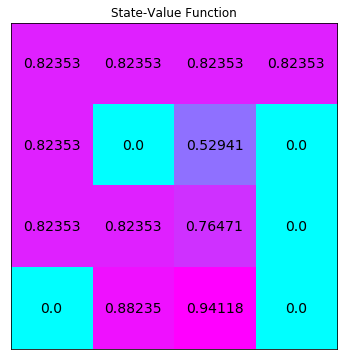

In [34]:
# obtain the optimal policy and optimal state-value function
policy_pi, V_pi = policy_iteration(env)

# print the optimal policy
print("\nOptimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):")
print(policy_pi,"\n")

plot_values(V_pi)

Run the code cell below to test your function.  If the code cell returns **PASSED**, then you have implemented the function correctly!  

**Note:** In order to ensure accurate results, make sure that the `policy_iteration` function satisfies the requirements outlined above (with three inputs, two outputs, and with the default values of the input arguments unchanged).

In [35]:
check_test.run_check('policy_iteration_check', policy_iteration)


Iteration: 0
Initial State: 0, State value improved by :0.0
Initial State: 1, State value improved by :0.0
Initial State: 2, State value improved by :0.0
Initial State: 3, State value improved by :0.0
Initial State: 4, State value improved by :0.0
Initial State: 5, State value improved by :0.0
Initial State: 6, State value improved by :0.0
Initial State: 7, State value improved by :0.0
Initial State: 8, State value improved by :0.0
Initial State: 9, State value improved by :0.0
Initial State: 10, State value improved by :0.0
Initial State: 11, State value improved by :0.0
Initial State: 12, State value improved by :0.0
Initial State: 13, State value improved by :0.0
Initial State: 14, State value improved by :0.25
Initial State: 15, State value improved by :0.0

Iteration: 1
Initial State: 0, State value improved by :0.0
Initial State: 1, State value improved by :0.0
Initial State: 2, State value improved by :0.0
Initial State: 3, State value improved by :0.0
Initial State: 4, State v

Initial State: 11, State value improved by :0.0
Initial State: 12, State value improved by :0.0
Initial State: 13, State value improved by :0.7273867083831229
Initial State: 14, State value improved by :0.8622330783038072
Initial State: 15, State value improved by :0.0

Iteration: 25
Initial State: 0, State value improved by :0.39016350788435755
Initial State: 1, State value improved by :0.33906705822658023
Initial State: 2, State value improved by :0.31150317777591047
Initial State: 3, State value improved by :0.2904273502066577
Initial State: 4, State value improved by :0.4388651905153857
Initial State: 5, State value improved by :0.0
Initial State: 6, State value improved by :0.2987377693602414
Initial State: 7, State value improved by :0.0
Initial State: 8, State value improved by :0.5141539130285758
Initial State: 9, State value improved by :0.6087502505721708
Initial State: 10, State value improved by :0.5899070327454063
Initial State: 11, State value improved by :0.0
Initial Sta

Initial State: 15, State value improved by :0.0

Iteration: 113
Initial State: 0, State value improved by :0.7714122910256964
Initial State: 1, State value improved by :0.6511047105985236
Initial State: 2, State value improved by :0.5313504750805886
Initial State: 3, State value improved by :0.5308493191661546
Initial State: 4, State value improved by :0.7725518933175357
Initial State: 5, State value improved by :0.0
Initial State: 6, State value improved by :0.41194250825896545
Initial State: 7, State value improved by :0.0
Initial State: 8, State value improved by :0.7743081318643206
Initial State: 9, State value improved by :0.776508177258932
Initial State: 10, State value improved by :0.7045959225709095
Initial State: 11, State value improved by :0.0
Initial State: 12, State value improved by :0.0
Initial State: 13, State value improved by :0.8508615365566434
Initial State: 14, State value improved by :0.9253995395838248
Initial State: 15, State value improved by :0.0

Iteration: 1

Initial State: 1, State value improved by :0.6583640033893963
Initial State: 2, State value improved by :0.5364638019381675
Initial State: 3, State value improved by :0.5364521641642632
Initial State: 4, State value improved by :0.780303518228316
Initial State: 5, State value improved by :0.0
Initial State: 6, State value improved by :0.4145716414911087
Initial State: 7, State value improved by :0.0
Initial State: 8, State value improved by :0.7803443013589556
Initial State: 9, State value improved by :0.780395390511341
Initial State: 10, State value improved by :0.7072538829847477
Initial State: 11, State value improved by :0.0
Initial State: 12, State value improved by :0.0
Initial State: 13, State value improved by :0.8535935850343477
Initial State: 14, State value improved by :0.9267960673287137
Initial State: 15, State value improved by :0.0

Iteration: 202
Initial State: 0, State value improved by :0.7802858757695773
Initial State: 1, State value improved by :0.6583712270323803
I

Initial State: 5, State value improved by :0.0
Initial State: 6, State value improved by :0.41463269486240106
Initial State: 7, State value improved by :0.0
Initial State: 8, State value improved by :0.78048447245901
Initial State: 9, State value improved by :0.7804856588442995
Initial State: 10, State value improved by :0.7073156057768992
Initial State: 11, State value improved by :0.0
Initial State: 12, State value improved by :0.0
Initial State: 13, State value improved by :0.8536570282893559
Initial State: 14, State value improved by :0.9268284973044509
Initial State: 15, State value improved by :0.0

Iteration: 290
Initial State: 0, State value improved by :0.780483115707987
Initial State: 1, State value improved by :0.6585327454373131
Initial State: 2, State value improved by :0.5365826610709333
Initial State: 3, State value improved by :0.536582402131842
Initial State: 4, State value improved by :0.7804837045219136
Initial State: 5, State value improved by :0.0
Initial State: 6,

Initial State: 8, State value improved by :0.3236668777599669
Initial State: 9, State value improved by :0.47282983608072576
Initial State: 10, State value improved by :0.4842812245893535
Initial State: 11, State value improved by :0.0
Initial State: 12, State value improved by :0.0
Initial State: 13, State value improved by :0.6333459440537507
Initial State: 14, State value improved by :0.8132645998347723
Initial State: 15, State value improved by :0.0

Iteration: 14
Initial State: 0, State value improved by :0.16502003994591177
Initial State: 1, State value improved by :0.09763534071157032
Initial State: 2, State value improved by :0.05829281851961761
Initial State: 3, State value improved by :0.03983604483269125
Initial State: 4, State value improved by :0.23320106283724604
Initial State: 5, State value improved by :0.0
Initial State: 6, State value improved by :0.18085801436965704
Initial State: 7, State value improved by :0.0
Initial State: 8, State value improved by :0.3432325922

Initial State: 12, State value improved by :0.0
Initial State: 13, State value improved by :0.8704133133664886
Initial State: 14, State value improved by :0.9351012833832477
Initial State: 15, State value improved by :0.0

Iteration: 102
Initial State: 0, State value improved by :0.7927702549213875
Initial State: 1, State value improved by :0.7826909244816586
Initial State: 2, State value improved by :0.7756865260669662
Initial State: 3, State value improved by :0.7721226834351035
Initial State: 4, State value improved by :0.7958652133227717
Initial State: 5, State value improved by :0.0
Initial State: 6, State value improved by :0.508446688151279
Initial State: 7, State value improved by :0.0
Initial State: 8, State value improved by :0.800711886853438
Initial State: 9, State value improved by :0.8069262462022657
Initial State: 10, State value improved by :0.7501580725789307
Initial State: 11, State value improved by :0.0
Initial State: 12, State value improved by :0.0
Initial State: 

Initial State: 15, State value improved by :0.0

Iteration: 190
Initial State: 0, State value improved by :0.8220001548115295
Initial State: 1, State value improved by :0.8214984255202475
Initial State: 2, State value improved by :0.821149718387755
Initial State: 3, State value improved by :0.8209722869689567
Initial State: 4, State value improved by :0.8221539842076175
Initial State: 5, State value improved by :0.0
Initial State: 6, State value improved by :0.5283690040868272
Initial State: 7, State value improved by :0.0
Initial State: 8, State value improved by :0.8223948926771416
Initial State: 9, State value improved by :0.8227038049457742
Initial State: 10, State value improved by :0.7639823942552197
Initial State: 11, State value improved by :0.0
Initial State: 12, State value improved by :0.0
Initial State: 13, State value improved by :0.8817791356554289
Initial State: 14, State value improved by :0.9408845031294955
Initial State: 15, State value improved by :0.0

Iteration: 19

Initial State: 2, State value improved by :0.8234110840120639
Initial State: 3, State value improved by :0.8234022614085386
Initial State: 4, State value improved by :0.8234610201189689
Initial State: 5, State value improved by :0.0
Initial State: 6, State value improved by :0.5293599145326291
Initial State: 7, State value improved by :0.0
Initial State: 8, State value improved by :0.8234729990270273
Initial State: 9, State value improved by :0.8234883593506743
Initial State: 10, State value improved by :0.7646699076763461
Initial State: 11, State value improved by :0.0
Initial State: 12, State value improved by :0.0
Initial State: 13, State value improved by :0.8823244093118605
Initial State: 14, State value improved by :0.9411619528191986
Initial State: 15, State value improved by :0.0

Iteration: 279
Initial State: 0, State value improved by :0.8234559207879746
Initial State: 1, State value improved by :0.8234318093104679
Initial State: 2, State value improved by :0.8234150515770234

Initial State: 5, State value improved by :0.0
Initial State: 6, State value improved by :0.5294091865117506
Initial State: 7, State value improved by :0.0
Initial State: 8, State value improved by :0.8235266067019642
Initial State: 9, State value improved by :0.8235273704775459
Initial State: 10, State value improved by :0.7647040935508167
Initial State: 11, State value improved by :0.0
Initial State: 12, State value improved by :0.0
Initial State: 13, State value improved by :0.8823515224601719
Initial State: 14, State value improved by :0.941175748707775
Initial State: 15, State value improved by :0.0

Iteration: 367
Initial State: 0, State value improved by :0.823525757504886
Initial State: 1, State value improved by :0.8235245585875824
Initial State: 2, State value improved by :0.8235237253272982
Initial State: 3, State value improved by :0.8235233013423775
Initial State: 4, State value improved by :0.8235261250901627
Initial State: 5, State value improved by :0.0
Initial State: 6

Initial State: 9, State value improved by :0.8235293102638944
Initial State: 10, State value improved by :0.764705793406677
Initial State: 11, State value improved by :0.0
Initial State: 12, State value improved by :0.0
Initial State: 13, State value improved by :0.8823528706323265
Initial State: 14, State value improved by :0.9411764346935048
Initial State: 15, State value improved by :0.0

Iteration: 455
Initial State: 0, State value improved by :0.8235292300605618
Initial State: 1, State value improved by :0.8235291704456873
Initial State: 2, State value improved by :0.823529129012715
Initial State: 3, State value improved by :0.8235291079305205
Initial State: 4, State value improved by :0.8235292483383446
Initial State: 5, State value improved by :0.0
Initial State: 6, State value improved by :0.529411640806464
Initial State: 7, State value improved by :0.0
Initial State: 8, State value improved by :0.8235292769627377
Initial State: 9, State value improved by :0.823529313667247
Ini

**<span style="color: green;">PASSED</span>**

## Truncated Policy Iteration

In this section, you will write your own implementation of truncated policy iteration.  

You will begin by implementing truncated policy evaluation.  Your algorithm should accept five arguments as **input**:
- `env`: This is an instance of an OpenAI Gym environment, where `env.P` returns the one-step dynamics.
- `policy`: This is a 2D numpy array with `policy.shape[0]` equal to the number of states (`env.nS`), and `policy.shape[1]` equal to the number of actions (`env.nA`).  `policy[s][a]` returns the probability that the agent takes action `a` while in state `s` under the policy.
- `V`: This is a 1D numpy array with `V.shape[0]` equal to the number of states (`env.nS`).  `V[s]` contains the estimated value of state `s`.
- `max_it`: This is a positive integer that corresponds to the number of sweeps through the state space (default value: `1`).
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as **output**:
- `V`: This is a 1D numpy array with `V.shape[0]` equal to the number of states (`env.nS`).  `V[s]` contains the estimated value of state `s`.

Please complete the function in the code cell below.
<img src="images/truncated-eval.png" width="600">

In [36]:
def truncated_policy_evaluation(env, policy, V, max_it=1, gamma=1):
    num_it=0
    while num_it < max_it:
        for s in range(env.nS):
            v = 0
            q = q_from_v(env, V, s, gamma)
            for a, action_prob in enumerate(policy[s]):
                v += action_prob * q[a]
            V[s] = v
        num_it += 1
    return V

Next, you will implement truncated policy iteration.  Your algorithm should accept five arguments as **input**:
- `env`: This is an instance of an OpenAI Gym environment, where `env.P` returns the one-step dynamics.
- `max_it`: This is a positive integer that corresponds to the number of sweeps through the state space (default value: `1`).
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).
- `theta`: This is a very small positive number that is used for the stopping criterion (default value: `1e-8`).

The algorithm returns as **output**:
- `policy`: This is a 2D numpy array with `policy.shape[0]` equal to the number of states (`env.nS`), and `policy.shape[1]` equal to the number of actions (`env.nA`).  `policy[s][a]` returns the probability that the agent takes action `a` while in state `s` under the policy.
- `V`: This is a 1D numpy array with `V.shape[0]` equal to the number of states (`env.nS`).  `V[s]` contains the estimated value of state `s`.

Please complete the function in the code cell below.
<img src="images/truncated-iter.png" width="600">

In [37]:
def truncated_policy_iteration(env, max_it=1, gamma=1, theta=1e-8):
    V = np.zeros(env.nS)
    policy = np.zeros([env.nS, env.nA]) / env.nA
    while True:
        policy = policy_improvement(env, V)
        old_V = copy.copy(V)
        V = truncated_policy_evaluation(env, policy, V, max_it, gamma)
        if max(abs(V-old_V)) < theta:
            break;
    return policy, V

Run the next code cell to solve the MDP and visualize the output.  The state-value function has been reshaped to match the shape of the gridworld.

Play with the value of the `max_it` argument.  Do you always end with the optimal state-value function?

State Values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

State: 0, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 1, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 2, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 3, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 4, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 5, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 6, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 7, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 8, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 9, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 10, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 11, Action value: [0. 0. 0. 0.]
Best Action for next episo

State: 1, Action value: [0.31077463 0.29632838 0.27426927 0.44068614]
Best Action for next episode: [3]

State: 2, Action value: [0.38654545 0.3793831  0.36493685 0.39701843]
Best Action for next episode: [3]

State: 3, Action value: [0.25266067 0.25266067 0.24549832 0.37540983]
Best Action for next episode: [3]

State: 4, Action value: [0.54095915 0.37454227 0.36277537 0.34460066]
Best Action for next episode: [0]

State: 5, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 6, Action value: [0.33825832 0.20834681 0.33825832 0.12991151]
Best Action for next episode: [0 2]

State: 7, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 8, Action value: [0.37454227 0.41559065 0.39741593 0.59377443]
Best Action for next episode: [3]

State: 9, Action value: [0.45208689 0.6604337  0.46407521 0.4047053 ]
Best Action for next episode: [1]

State: 10, Action value: [0.62570628 0.5134301  0.40647412 0.33150833]
Best Action for next episode: [0]


State: 8, Action value: [0.49558444 0.50736438 0.50219757 0.7525732 ]
Best Action for next episode: [3]

State: 9, Action value: [0.53231735 0.77191353 0.5215379  0.48997181]
Best Action for next episode: [1]

State: 10, Action value: [0.7190029  0.56451911 0.46201415 0.41147255]
Best Action for next episode: [0]

State: 11, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 12, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 13, Action value: [0.53893047 0.58947207 0.84646083 0.56451911]
Best Action for next episode: [2]

State: 14, Action value: [0.82906826 0.92280541 0.88045987 0.85487124]
Best Action for next episode: [1]

State: 15, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

Matrix best Action for next episode's each state:
 [[1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.5  0.   0.5  0.  ]
 [0.25 0.25 0.25 0.2

Best Action for next episode: [1]

State: 10, Action value: [0.75126567 0.58128095 0.48189339 0.43935699]
Best Action for next episode: [0]

State: 11, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 12, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 13, Action value: [0.55991932 0.60245572 0.87182799 0.58128095]
Best Action for next episode: [2]

State: 14, Action value: [0.8528566  0.93578905 0.89564289 0.87428126]
Best Action for next episode: [1]

State: 15, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

Matrix best Action for next episode's each state:
 [[1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.5  0.   0.5  0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   1.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.   0.   1.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25


State: 11, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 12, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 13, Action value: [0.56589624 0.60615342 0.8790519  0.58605414]
Best Action for next episode: [2]

State: 14, Action value: [0.85964338 0.93948675 0.89997896 0.87982106]
Best Action for next episode: [1]

State: 15, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

Matrix best Action for next episode's each state:
 [[1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.5  0.   0.5  0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   1.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.   0.   1.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]]
State Values: [0.81516571 0.81242212 0.81051533 0.80954511 0.81600705 0.
 0.52370908 0.         0.81732465 0.81901416 0.7607491

Best Action for next episode: [1]

State: 15, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

Matrix best Action for next episode's each state:
 [[1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.5  0.   0.5  0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   1.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.   0.   1.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]]
State Values: [0.82052307 0.81953674 0.81885123 0.81850243 0.82082548 0.
 0.52736183 0.         0.82129908 0.82190637 0.76328359 0.
 0.         0.88122491 0.9406025  0.        ]

State: 0, Action value: [0.82062387 0.82029509 0.82029509 0.82019429]
Best Action for next episode: [0]

State: 1, Action value: [0.5466866  0.5464581  0.54612932 0.81963701]
Best Action for next episode: [3]

State: 2, Action value: [0.7219166  0.72180033 0.72157183 0.81896347]
Best A

State: 15, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

Matrix best Action for next episode's each state:
 [[1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.5  0.   0.5  0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   1.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.   0.   1.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]]
State Values: [0.82258657 0.82227724 0.82206225 0.82195285 0.82268141 0.
 0.52876887 0.         0.82282994 0.8230204  0.76425983 0.
 0.         0.88199917 0.94099646 0.        ]

State: 0, Action value: [0.82261818 0.82251507 0.82251507 0.82248346]
Best Action for next episode: [0]

State: 1, Action value: [0.54828794 0.54821627 0.54811316 0.82230868]
Best Action for next episode: [3]

State: 2, Action value: [0.72436945 0.72433299 0.72426132 0.82209745]
Best Action for next episode: [3]

State:


State: 14, Action value: [0.86264267 0.94112067 0.90189534 0.88226933]
Best Action for next episode: [1]

State: 15, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

Matrix best Action for next episode's each state:
 [[1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.5  0.   0.5  0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   1.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.   0.   1.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]]
State Values: [0.82325322 0.8231626  0.82309962 0.82306758 0.823281   0.
 0.52922343 0.         0.82332451 0.8233803  0.76457522 0.
 0.         0.88224931 0.94112374 0.        ]

State: 0, Action value: [0.82326248 0.82323227 0.82323227 0.82322301]
Best Action for next episode: [0]

State: 1, Action value: [0.54880527 0.54878428 0.54875407 0.82317181]
Best Action for next episode: [3]

Stat


State: 6, Action value: [0.52935318 0.2548883  0.52935318 0.27446487]
Best Action for next episode: [0 2]

State: 7, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 8, Action value: [0.54897222 0.5489826  0.54897805 0.82346643]
Best Action for next episode: [3]

State: 9, Action value: [0.5685952  0.8234835  0.54899511 0.52937668]
Best Action for next episode: [1]

State: 10, Action value: [0.76466509 0.58821419 0.49017088 0.45094512]
Best Action for next episode: [0]

State: 11, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 12, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 13, Action value: [0.56860103 0.60782679 0.88232101 0.58821419]
Best Action for next episode: [2]

State: 14, Action value: [0.86271509 0.94116012 0.90194161 0.88232845]
Best Action for next episode: [1]

State: 15, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

Matrix best Action for next episode's each st

State: 4, Action value: [0.82350549 0.54900475 0.54900383 0.54900241]
Best Action for next episode: [0]

State: 5, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 6, Action value: [0.52939339 0.25489768 0.52939339 0.27449571]
Best Action for next episode: [0 2]

State: 7, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 8, Action value: [0.54900475 0.549008   0.54900657 0.82350966]
Best Action for next episode: [3]

State: 9, Action value: [0.56861734 0.82351501 0.54901193 0.52940076]
Best Action for next episode: [1]

State: 10, Action value: [0.76469309 0.58822868 0.49018818 0.45096933]
Best Action for next episode: [0]

State: 11, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 12, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 13, Action value: [0.56861916 0.60783801 0.88234293 0.58822868]
Best Action for next episode: [2]

State: 14, Action value: [0.86273569 0.94117134 

State: 0, Action value: [0.82352223 0.82352142 0.82352142 0.82352117]
Best Action for next episode: [0]

State: 1, Action value: [0.54901384 0.54901327 0.54901246 0.82351979]
Best Action for next episode: [3]

State: 2, Action value: [0.72548136 0.72548107 0.72548051 0.82351812]
Best Action for next episode: [3]

State: 3, Action value: [0.54901161 0.54901161 0.54901132 0.82351727]
Best Action for next episode: [3]

State: 4, Action value: [0.82352287 0.54901554 0.54901529 0.5490149 ]
Best Action for next episode: [0]

State: 5, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 6, Action value: [0.52940674 0.25490079 0.52940674 0.27450595]
Best Action for next episode: [0 2]

State: 7, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 8, Action value: [0.54901554 0.54901643 0.54901604 0.82352401]
Best Action for next episode: [3]

State: 9, Action value: [0.56862468 0.82352547 0.54901751 0.52940875]
Best Action for next episode: [1]




State: 7, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 8, Action value: [0.5490185  0.54901874 0.54901863 0.82352793]
Best Action for next episode: [3]

State: 9, Action value: [0.56862669 0.82352833 0.54901903 0.52941094]
Best Action for next episode: [1]

State: 10, Action value: [0.76470492 0.5882348  0.49019549 0.45097956]
Best Action for next episode: [0]

State: 11, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 12, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 13, Action value: [0.56862683 0.60784275 0.88235219 0.5882348 ]
Best Action for next episode: [2]

State: 14, Action value: [0.86274439 0.94117609 0.90196033 0.88235237]
Best Action for next episode: [1]

State: 15, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

Matrix best Action for next episode's each state:
 [[1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [1.   0.

State: 13, Action value: [0.56862727 0.60784302 0.88235272 0.58823515]
Best Action for next episode: [2]

State: 14, Action value: [0.86274489 0.94117636 0.90196065 0.88235277]
Best Action for next episode: [1]

State: 15, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

Matrix best Action for next episode's each state:
 [[1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.5  0.   0.5  0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   1.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.   0.   1.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]]
State Values: [0.82352886 0.82352867 0.82352855 0.82352848 0.82352891 0.
 0.52941139 0.         0.823529   0.82352911 0.76470562 0.
 0.         0.88235273 0.94117636 0.        ]

State: 0, Action value: [0.82352887 0.82352881 0.82352881 0.82352879]
Best Action for next episode: [0]

Stat

State: 9, Action value: [0.56862738 0.82352931 0.54901955 0.52941168]
Best Action for next episode: [1]

State: 10, Action value: [0.76470579 0.58823525 0.49019602 0.45098031]
Best Action for next episode: [0]

State: 11, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 12, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 13, Action value: [0.56862739 0.6078431  0.88235287 0.58823525]
Best Action for next episode: [2]

State: 14, Action value: [0.86274503 0.94117643 0.90196074 0.88235288]
Best Action for next episode: [1]

State: 15, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

Matrix best Action for next episode's each state:
 [[1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.5  0.   0.5  0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   1.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.2

/Users/dhanushanthp/anaconda3/envs/quadcop/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


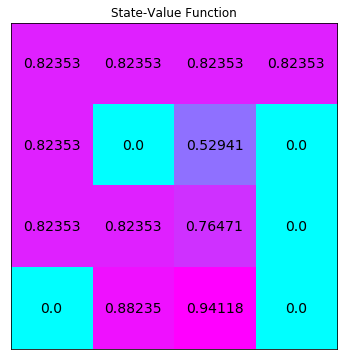

In [38]:
policy_tpi, V_tpi = truncated_policy_iteration(env, max_it=2)

# print the optimal policy
print("\nOptimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):")
print(policy_tpi,"\n")

# plot the optimal state-value function
plot_values(V_tpi)

Run the code cell below to test your function.  If the code cell returns **PASSED**, then you have implemented the function correctly!  

**Note:** In order to ensure accurate results, make sure that the `truncated_policy_iteration` function satisfies the requirements outlined above (with four inputs, two outputs, and with the default values of the input arguments unchanged).

In [39]:
check_test.run_check('truncated_policy_iteration_check', truncated_policy_iteration)

State Values: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

State: 0, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 1, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 2, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 3, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 4, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 5, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 6, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 7, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 8, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 9, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 10, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 11, Action value: [0. 0. 0. 0.]
Best Action for next episo

State: 9, Action value: [0.3616657  0.5417318  0.40673542 0.31506247]
Best Action for next episode: [1]

State: 10, Action value: [0.54176799 0.4578926  0.36309186 0.26255151]
Best Action for next episode: [0]

State: 11, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 12, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 13, Action value: [0.40534545 0.5058858  0.68456192 0.4578926 ]
Best Action for next episode: [2]

State: 14, Action value: [0.68595189 0.83921913 0.7926159  0.74006875]
Best Action for next episode: [1]

State: 15, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

Matrix best Action for next episode's each state:
 [[1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.5  0.   0.5  0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   1.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.2


State: 9, Action value: [0.46144816 0.67312048 0.470381   0.41441179]
Best Action for next episode: [1]

State: 10, Action value: [0.6356299  0.51923513 0.4121093  0.33991537]
Best Action for next episode: [0]

State: 11, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 12, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 13, Action value: [0.48222929 0.55442322 0.77794382 0.51923513]
Best Action for next episode: [2]

State: 14, Action value: [0.76609554 0.88775656 0.84072018 0.80371434]
Best Action for next episode: [1]

State: 15, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

Matrix best Action for next episode's each state:
 [[1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.5  0.   0.5  0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   1.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.

Best Action for next episode: [3]

State: 4, Action value: [0.67107324 0.45446195 0.44849365 0.43919088]
Best Action for next episode: [0]

State: 5, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 6, Action value: [0.41627462 0.22822463 0.41627462 0.18804999]
Best Action for next episode: [0 2]

State: 7, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 8, Action value: [0.45446195 0.47562098 0.46631821 0.69820057]
Best Action for next episode: [3]

State: 9, Action value: [0.50462182 0.73284645 0.50096409 0.460107  ]
Best Action for next episode: [1]

State: 10, Action value: [0.68504781 0.54658806 0.44130919 0.38219837]
Best Action for next episode: [0]

State: 11, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 12, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 13, Action value: [0.51647808 0.57558889 0.81932751 0.54658806]
Best Action for next episode: [2]

State: 14, Ac

State: 15, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

Matrix best Action for next episode's each state:
 [[1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.5  0.   0.5  0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   1.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.   0.   1.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]]
State Values: [0.72023454 0.68757368 0.66495785 0.65346829 0.73071122 0.
 0.4598528  0.         0.74709209 0.76805355 0.71626317 0.
 0.         0.84380157 0.92156157 0.        ]

State: 0, Action value: [0.72372677 0.71283982 0.71283982 0.70934759]
Best Action for next episode: [0]

State: 1, Action value: [0.46926941 0.4617308  0.45084384 0.69092203]
Best Action for next episode: [3]

State: 2, Action value: [0.60412811 0.60029826 0.59275965 0.66866661]
Best Action for next episode: [3]

State:


State: 13, Action value: [0.55221752 0.59769106 0.86251943 0.57513027]
Best Action for next episode: [2]

State: 14, Action value: [0.84411644 0.93102439 0.89006062 0.86714787]
Best Action for next episode: [1]

State: 15, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

Matrix best Action for next episode's each state:
 [[1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.5  0.   0.5  0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   1.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.   0.   1.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]]
State Values: [0.77147166 0.75453449 0.74277269 0.73679005 0.77671817 0.
 0.49401628 0.         0.78493156 0.79545839 0.74012679 0.
 0.         0.86284386 0.93124985 0.        ]

State: 0, Action value: [0.77322049 0.76757477 0.76757477 0.76582593]
Best Action for next episode: [0]

Sta

Best Action for next episode: [0]

State: 5, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 6, Action value: [0.51101852 0.2506128  0.51101852 0.26040572]
Best Action for next episode: [0 2]

State: 7, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 8, Action value: [0.53413356 0.53739577 0.53596631 0.80374782]
Best Action for next episode: [3]

State: 9, Action value: [0.55849673 0.80910953 0.54132802 0.51839431]
Best Action for next episode: [1]

State: 10, Action value: [0.75189845 0.58160851 0.48228418 0.4399042 ]
Best Action for next episode: [0]

State: 11, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 12, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 13, Action value: [0.56032948 0.60270947 0.87232373 0.58160851]
Best Action for next episode: [2]

State: 14, Action value: [0.85332227 0.9360428  0.89594038 0.87466135]
Best Action for next episode: [1]

State: 15, A

State: 3, Action value: [0.53370815 0.53370815 0.53315806 0.80028718]
Best Action for next episode: [3]

State: 4, Action value: [0.81099954 0.54123366 0.54075641 0.54000901]
Best Action for next episode: [0]

State: 5, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 6, Action value: [0.51978702 0.25265789 0.51978702 0.26712912]
Best Action for next episode: [0 2]

State: 7, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 8, Action value: [0.54123366 0.54293939 0.542192   0.81318253]
Best Action for next episode: [3]

State: 9, Action value: [0.5633283  0.81598619 0.54499567 0.52364842]
Best Action for next episode: [1]

State: 10, Action value: [0.7580051  0.58476871 0.48605623 0.44518526]
Best Action for next episode: [0]

State: 11, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 12, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 13, Action value: [0.56428664 0.60515762 0

State: 6, Action value: [0.52364082 0.25355648 0.52364082 0.27008434]
Best Action for next episode: [0 2]

State: 7, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 8, Action value: [0.54435167 0.54537424 0.54492619 0.81732605]
Best Action for next episode: [3]

State: 9, Action value: [0.56545037 0.81900685 0.54660699 0.52595634]
Best Action for next episode: [1]

State: 10, Action value: [0.76068827 0.58615689 0.48771389 0.44750577]
Best Action for next episode: [0]

State: 11, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 12, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 13, Action value: [0.5660249  0.60623302 0.8792074  0.58615689]
Best Action for next episode: [2]

State: 14, Action value: [0.8597895  0.93956635 0.90007232 0.87994033]
Best Action for next episode: [1]

State: 15, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

Matrix best Action for next episode's each sta

State: 1, Action value: [0.5450499  0.5446611  0.5441017  0.81690635]
Best Action for next episode: [3]

State: 2, Action value: [0.71940961 0.71921178 0.71882299 0.81576032]
Best Action for next episode: [3]

State: 3, Action value: [0.54351508 0.54351508 0.54331725 0.8151737 ]
Best Action for next episode: [3]

State: 4, Action value: [0.81902563 0.54622098 0.54604945 0.54578083]
Best Action for next episode: [0]

State: 5, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 6, Action value: [0.52595172 0.25409527 0.52595172 0.27185645]
Best Action for next episode: [0 2]

State: 7, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 8, Action value: [0.54622098 0.54683404 0.54656542 0.81981022]
Best Action for next episode: [3]

State: 9, Action value: [0.56672265 0.82081791 0.54757312 0.52734007]
Best Action for next episode: [1]

State: 10, Action value: [0.7622971  0.58698919 0.48870785 0.44889715]
Best Action for next episode: [0]


State: 3, Action value: [0.54593695 0.54593695 0.54582616 0.81885003]
Best Action for next episode: [3]

State: 4, Action value: [0.82100723 0.54745233 0.54735628 0.54720585]
Best Action for next episode: [0]

State: 5, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 6, Action value: [0.52747407 0.2544502  0.52747407 0.27302387]
Best Action for next episode: [0 2]

State: 7, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 8, Action value: [0.54745233 0.54779566 0.54764523 0.82144661]
Best Action for next episode: [3]

State: 9, Action value: [0.56756073 0.82201093 0.54820955 0.52825158]
Best Action for next episode: [1]

State: 10, Action value: [0.76335692 0.58753745 0.48936264 0.44981374]
Best Action for next episode: [0]

State: 11, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 12, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 13, Action value: [0.56775362 0.60730253 0

State: 8, Action value: [0.54819978 0.54837937 0.54830068 0.82243992]
Best Action for next episode: [3]

State: 9, Action value: [0.56806946 0.82273511 0.54859587 0.52880488]
Best Action for next episode: [1]

State: 10, Action value: [0.76400025 0.58787026 0.48976012 0.45037013]
Best Action for next episode: [0]

State: 11, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 12, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 13, Action value: [0.56817036 0.60756035 0.88180049 0.58787026]
Best Action for next episode: [2]

State: 14, Action value: [0.862226   0.94089368 0.90162911 0.88192921]
Best Action for next episode: [1]

State: 15, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

Matrix best Action for next episode's each state:
 [[1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.5  0.   0.5  0.  ]
 [0.25 0.25 0.25 0.2


State: 2, Action value: [0.72464906 0.72462169 0.7245679  0.82245469]
Best Action for next episode: [3]

State: 3, Action value: [0.54825815 0.54825815 0.54823078 0.82237354]
Best Action for next episode: [3]

State: 4, Action value: [0.8229064  0.54863247 0.54860875 0.54857159]
Best Action for next episode: [0]

State: 5, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 6, Action value: [0.52893313 0.25479037 0.52893313 0.27414276]
Best Action for next episode: [0 2]

State: 7, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 8, Action value: [0.54863247 0.54871728 0.54868012 0.82301493]
Best Action for next episode: [3]

State: 9, Action value: [0.56836396 0.82315433 0.54881951 0.52912519]
Best Action for next episode: [1]

State: 10, Action value: [0.76437267 0.58806292 0.48999021 0.45069221]
Best Action for next episode: [0]

State: 11, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 12, Action value

State: 9, Action value: [0.56846947 0.82330453 0.54889964 0.52923995]
Best Action for next episode: [1]

State: 10, Action value: [0.76450611 0.58813195 0.49007265 0.45080762]
Best Action for next episode: [0]

State: 11, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 12, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 13, Action value: [0.56849804 0.60776308 0.88219653 0.58813195]
Best Action for next episode: [2]

State: 14, Action value: [0.86259813 0.94109641 0.90186688 0.88223297]
Best Action for next episode: [1]

State: 15, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

Matrix best Action for next episode's each state:
 [[1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.5  0.   0.5  0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   1.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.2


State: 4, Action value: [0.82334691 0.5489062  0.54889925 0.54888837]
Best Action for next episode: [0]

State: 5, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 6, Action value: [0.52927155 0.25486927 0.52927155 0.27440228]
Best Action for next episode: [0 2]

State: 7, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 8, Action value: [0.5489062  0.54893104 0.54892016 0.8233787 ]
Best Action for next episode: [3]

State: 9, Action value: [0.56855026 0.82341954 0.54896099 0.52932781]
Best Action for next episode: [1]

State: 10, Action value: [0.76460827 0.5881848  0.49013577 0.45089597]
Best Action for next episode: [0]

State: 11, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 12, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 13, Action value: [0.56856422 0.60780402 0.88227652 0.5881848 ]
Best Action for next episode: [2]

State: 14, Action value: [0.86267329 0.94113735

State: 13, Action value: [0.56859323 0.60782196 0.88231158 0.58820796]
Best Action for next episode: [2]

State: 14, Action value: [0.86270623 0.9411553  0.90193595 0.88232122]
Best Action for next episode: [1]

State: 15, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

Matrix best Action for next episode's each state:
 [[1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.5  0.   0.5  0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   1.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.   0.   1.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]]
State Values: [0.82342098 0.82338541 0.82336068 0.8233481  0.82343189 0.
 0.52933783 0.         0.82344897 0.82347087 0.76465458 0.
 0.         0.88231226 0.94115577 0.        ]

State: 0, Action value: [0.82342462 0.82341276 0.82341276 0.82340912]
Best Action for next episode: [0]

Stat

State: 5, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 6, Action value: [0.5293734  0.25489302 0.5293734  0.27448038]
Best Action for next episode: [0 2]

State: 7, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 8, Action value: [0.54898858 0.54899537 0.5489924  0.82348817]
Best Action for next episode: [3]

State: 9, Action value: [0.56860633 0.82349935 0.54900357 0.52938879]
Best Action for next episode: [1]

State: 10, Action value: [0.76467917 0.58822148 0.49017958 0.45095729]
Best Action for next episode: [0]

State: 11, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 12, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 13, Action value: [0.56861015 0.60783243 0.88233203 0.58822148]
Best Action for next episode: [2]

State: 14, Action value: [0.86272545 0.94116577 0.90194823 0.8823369 ]
Best Action for next episode: [1]

State: 15, Action value: [0. 0. 0. 0.]
Best Act


State: 14, Action value: [0.86273482 0.94117087 0.90195422 0.88234455]
Best Action for next episode: [1]

State: 15, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

Matrix best Action for next episode's each state:
 [[1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.5  0.   0.5  0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   1.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.   0.   1.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]]
State Values: [0.82350074 0.82349133 0.82348479 0.82348146 0.82350362 0.
 0.52939221 0.         0.82350814 0.82351393 0.76469232 0.
 0.         0.88234218 0.941171   0.        ]

State: 0, Action value: [0.8235017  0.82349856 0.82349856 0.8234976 ]
Best Action for next episode: [0]

State: 1, Action value: [0.54899736 0.54899518 0.54899204 0.82349229]
Best Action for next episode: [3]

Stat

State: 1, Action value: [0.54900836 0.54900726 0.54900567 0.82351064]
Best Action for next episode: [3]

State: 2, Action value: [0.72547296 0.7254724  0.7254713  0.82350739]
Best Action for next episode: [3]

State: 3, Action value: [0.54900401 0.54900401 0.54900345 0.82350573]
Best Action for next episode: [3]

State: 4, Action value: [0.82351665 0.54901168 0.54901119 0.54901043]
Best Action for next episode: [0]

State: 5, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 6, Action value: [0.52940196 0.25489967 0.52940196 0.27450228]
Best Action for next episode: [0 2]

State: 7, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 8, Action value: [0.54901168 0.54901341 0.54901265 0.82351887]
Best Action for next episode: [3]

State: 9, Action value: [0.56862205 0.82352173 0.54901551 0.52940589]
Best Action for next episode: [1]

State: 10, Action value: [0.76469906 0.58823176 0.49019186 0.45097449]
Best Action for next episode: [0]


Best Action for next episode: [3]

State: 2, Action value: [0.72548118 0.72548089 0.72548031 0.8235179 ]
Best Action for next episode: [3]

State: 3, Action value: [0.54901145 0.54901145 0.54901115 0.82351703]
Best Action for next episode: [3]

State: 4, Action value: [0.82352274 0.54901546 0.54901521 0.54901481]
Best Action for next episode: [0]

State: 5, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 6, Action value: [0.52940664 0.25490076 0.52940664 0.27450587]
Best Action for next episode: [0 2]

State: 7, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 8, Action value: [0.54901546 0.54901637 0.54901597 0.8235239 ]
Best Action for next episode: [3]

State: 9, Action value: [0.56862463 0.82352539 0.54901746 0.52940869]
Best Action for next episode: [1]

State: 10, Action value: [0.76470231 0.58823345 0.49019387 0.4509773 ]
Best Action for next episode: [0]

State: 11, Action value: [0. 0. 0. 0.]
Best Action for next episode: 

State: 13, Action value: [0.56862602 0.60784225 0.88235121 0.58823415]
Best Action for next episode: [2]

State: 14, Action value: [0.86274347 0.94117558 0.90195974 0.88235161]
Best Action for next episode: [1]

State: 15, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

Matrix best Action for next episode's each state:
 [[1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.5  0.   0.5  0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   1.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.   0.   1.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]]
State Values: [0.82352487 0.82352337 0.82352234 0.82352181 0.82352532 0.
 0.52940866 0.         0.82352604 0.82352696 0.76470373 0.
 0.         0.88235124 0.9411756  0.        ]

State: 0, Action value: [0.82352502 0.82352452 0.82352452 0.82352437]
Best Action for next episode: [0]

Stat


State: 2, Action value: [0.72548746 0.72548738 0.7254872  0.82352592]
Best Action for next episode: [3]

State: 3, Action value: [0.54901713 0.54901713 0.54901705 0.82352566]
Best Action for next episode: [3]

State: 4, Action value: [0.82352739 0.54901835 0.54901827 0.54901815]
Best Action for next episode: [0]

State: 5, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 6, Action value: [0.52941021 0.2549016  0.52941021 0.27450861]
Best Action for next episode: [0 2]

State: 7, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 8, Action value: [0.54901835 0.54901863 0.54901851 0.82352774]
Best Action for next episode: [3]

State: 9, Action value: [0.5686266  0.82352819 0.54901896 0.52941083]
Best Action for next episode: [1]

State: 10, Action value: [0.7647048  0.58823473 0.49019541 0.45097946]
Best Action for next episode: [0]

State: 11, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 12, Action value

State: 12, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 13, Action value: [0.5686271  0.60784292 0.88235251 0.58823501]
Best Action for next episode: [2]

State: 14, Action value: [0.8627447  0.94117625 0.90196053 0.88235261]
Best Action for next episode: [1]

State: 15, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

Matrix best Action for next episode's each state:
 [[1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.5  0.   0.5  0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   1.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.   0.   1.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]]
State Values: [0.82352829 0.82352792 0.82352766 0.82352753 0.8235284  0.
 0.529411   0.         0.82352858 0.82352881 0.76470535 0.
 0.         0.88235252 0.94117626 0.        ]

State: 0, Action value: [0.82

Best Action for next episode: [1]

State: 10, Action value: [0.76470559 0.58823514 0.4901959  0.45098014]
Best Action for next episode: [0]

State: 11, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 12, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 13, Action value: [0.56862726 0.60784302 0.88235271 0.58823514]
Best Action for next episode: [2]

State: 14, Action value: [0.86274488 0.94117635 0.90196065 0.88235276]
Best Action for next episode: [1]

State: 15, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

Matrix best Action for next episode's each state:
 [[1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.5  0.   0.5  0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   1.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.   0.   1.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25


State: 15, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

Matrix best Action for next episode's each state:
 [[1.   0.   0.   0.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [0.   0.   0.   1.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.5  0.   0.5  0.  ]
 [0.25 0.25 0.25 0.25]
 [0.   0.   0.   1.  ]
 [0.   1.   0.   0.  ]
 [1.   0.   0.   0.  ]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.   0.   1.   0.  ]
 [0.   1.   0.   0.  ]
 [0.25 0.25 0.25 0.25]]
State Values: [0.82352911 0.82352902 0.82352895 0.82352892 0.82352914 0.
 0.52941156 0.         0.82352919 0.82352925 0.76470574 0.
 0.         0.88235283 0.94117641 0.        ]

State: 0, Action value: [0.82352912 0.82352909 0.82352909 0.82352908]
Best Action for next episode: [0]

State: 1, Action value: [0.54901938 0.54901935 0.54901932 0.82352903]
Best Action for next episode: [3]

State: 2, Action value: [0.72548984 0.72548983 0.72548981 0.82352896]
Best Action for next episode: [3]

State

**<span style="color: green;">PASSED</span>**

## Value Iteration
<img src="images/value-iteration.png" width="600">
In this section, you will write your own implementation of value iteration.

Your algorithm should accept three arguments as input:
- `env`: This is an instance of an OpenAI Gym environment, where `env.P` returns the one-step dynamics.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).
- `theta`: This is a very small positive number that is used for the stopping criterion (default value: `1e-8`).

The algorithm returns as **output**:
- `policy`: This is a 2D numpy array with `policy.shape[0]` equal to the number of states (`env.nS`), and `policy.shape[1]` equal to the number of actions (`env.nA`).  `policy[s][a]` returns the probability that the agent takes action `a` while in state `s` under the policy.
- `V`: This is a 1D numpy array with `V.shape[0]` equal to the number of states (`env.nS`).  `V[s]` contains the estimated value of state `s`.

In [40]:
def value_iteration(env, gamma=1, theta=1e-8):
    V = np.zeros(env.nS)
    while True:
        delta = 0
        for s in range(env.nS):
            v = V[s]
            V[s] = max(q_from_v(env, V, s, gamma))
            delta = max(delta,abs(V[s]-v))
        if delta < theta:
            break
    policy = policy_improvement(env, V, gamma)
    return policy, V

Use the next code cell to solve the MDP and visualize the output.  The state-value function has been reshaped to match the shape of the gridworld.

State Values: [0.82352924 0.82352918 0.82352915 0.82352913 0.82352926 0.
 0.52941165 0.         0.82352928 0.82352932 0.7647058  0.
 0.         0.88235288 0.94117644 0.        ]

State: 0, Action value: [0.82352925 0.82352923 0.82352923 0.82352922]
Best Action for next episode: [0]

State: 1, Action value: [0.54901948 0.54901946 0.54901944 0.82352919]
Best Action for next episode: [3]

State: 2, Action value: [0.72548999 0.72548999 0.72548997 0.82352915]
Best Action for next episode: [3]

State: 3, Action value: [0.54901942 0.54901942 0.54901942 0.82352913]
Best Action for next episode: [3]

State: 4, Action value: [0.82352926 0.54901951 0.54901951 0.5490195 ]
Best Action for next episode: [0]

State: 5, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 6, Action value: [0.52941165 0.25490193 0.52941165 0.27450972]
Best Action for next episode: [0 2]

State: 7, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 8, Action value: [0.5490

/Users/dhanushanthp/anaconda3/envs/quadcop/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


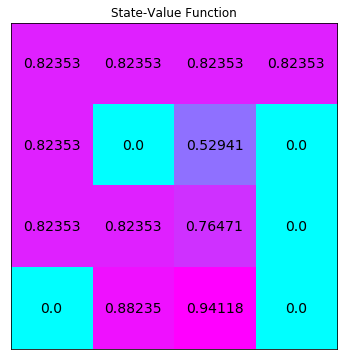

In [41]:
policy_vi, V_vi = value_iteration(env)

# print the optimal policy
print("\nOptimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):")
print(policy_vi,"\n")

# plot the optimal state-value function
plot_values(V_vi)

Run the code cell below to test your function.  If the code cell returns **PASSED**, then you have implemented the function correctly!  

**Note:** In order to ensure accurate results, make sure that the `value_iteration` function satisfies the requirements outlined above (with three inputs, two outputs, and with the default values of the input arguments unchanged).

In [42]:
check_test.run_check('value_iteration_check', value_iteration)

State Values: [0.82352924 0.82352918 0.82352915 0.82352913 0.82352926 0.
 0.52941165 0.         0.82352928 0.82352932 0.7647058  0.
 0.         0.88235288 0.94117644 0.        ]

State: 0, Action value: [0.82352925 0.82352923 0.82352923 0.82352922]
Best Action for next episode: [0]

State: 1, Action value: [0.54901948 0.54901946 0.54901944 0.82352919]
Best Action for next episode: [3]

State: 2, Action value: [0.72548999 0.72548999 0.72548997 0.82352915]
Best Action for next episode: [3]

State: 3, Action value: [0.54901942 0.54901942 0.54901942 0.82352913]
Best Action for next episode: [3]

State: 4, Action value: [0.82352926 0.54901951 0.54901951 0.5490195 ]
Best Action for next episode: [0]

State: 5, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 6, Action value: [0.52941165 0.25490193 0.52941165 0.27450972]
Best Action for next episode: [0 2]

State: 7, Action value: [0. 0. 0. 0.]
Best Action for next episode: [0 1 2 3]

State: 8, Action value: [0.5490

**<span style="color: green;">PASSED</span>**